In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from matplotlib.pyplot import subplots

In [2]:
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm

In [3]:
# Create helper functions for computing predictions and the mean squared error

def predict(X, model):
    # the built-in get_prediction tool returns an array, so we need to convert to a dataframe
    predictions_df = pd.DataFrame(model.get_prediction(X).predicted, columns=['y_hat'], index=X.index)
    return predictions_df['y_hat']

def mse(y, y_hat):
    # calculate the residual error for each individual record
    resid = y - y_hat
    # square the residual (hence "squared error")
    sq_resid = resid**2
    # calculate the sum of squared errors
    SSR = sum(sq_resid)
    # divide by the number of records to get the mean squared error
    MSE = SSR / y.shape[0]
    return MSE

In [4]:
# Randomly generate data using the equation y = x - 2x^2
rng = np.random.default_rng(1)
x = rng.normal(size=150)
y = x - 2 * x**2 + rng.normal(size=150)

In [5]:
# Create a data frame with columns we can use for modeling
new_x = pd.DataFrame(np.column_stack((x**0, x, x**2, x**3)), columns=['intercept','x','x_sq','x_cu'])
new_x

,intercept,x,x_sq,x_cu
0,1.0,0.345584,0.119428,0.041273
1,1.0,0.821618,0.675056,0.554639
2,1.0,0.330437,0.109189,0.036080
3,1.0,-1.303157,1.698219,-2.213046
4,1.0,0.905356,0.819669,0.742092
...,...,...,...,...
145,1.0,-0.420857,0.177121,-0.074542
146,1.0,-0.228535,0.052228,-0.011936
147,1.0,0.425149,0.180751,0.076846
148,1.0,0.282416,0.079759,0.022525


In [6]:
# Split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(new_x,
                                                    y,
                                                    random_state=314,
                                                    test_size=0.33,
                                                    shuffle=True) 

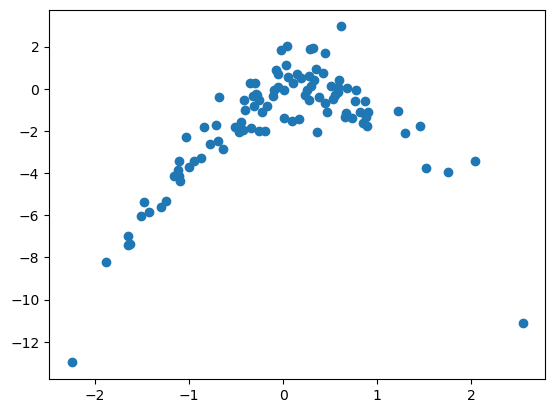

In [7]:
# Let's graph the data we created
fig, ax = plt.subplots()
ax.scatter(x_train['x'],y_train)

In [8]:
# Fit a linear model
model_lin = sm.OLS(y_train, x_train[['intercept','x']])
results_lin = model_lin.fit()
summarize(results_lin)

/Users/mjl09005/anaconda3/lib/python3.11/site-packages/ISLP/models/__init__.py:49: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  results_table = pd.read_html(tab.as_html(),


,coef,std err,t,P>|t|
intercept,-1.5702,0.241,-6.514,0.0
x,1.3307,0.278,4.783,0.0


In [9]:
# Get model predictions
predictions_lin_train = predict(x_train[['intercept', 'x']], results_lin)

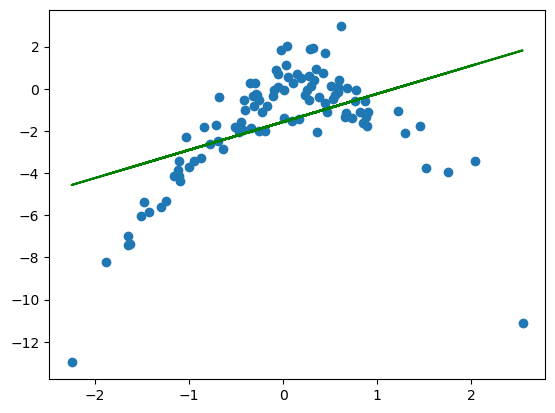

In [10]:
# Plot predictions as solid line
fig, ax = plt.subplots()
ax.scatter(x_train['x'],y_train)
ax.plot(x_train['x'],predictions_lin_train, color='green')

In [11]:
# Fit a quadratic model
model_quad = sm.OLS(y_train, x_train[['intercept','x','x_sq']])
results_quad = model_quad.fit()
summarize(results_quad)

/Users/mjl09005/anaconda3/lib/python3.11/site-packages/ISLP/models/__init__.py:49: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  results_table = pd.read_html(tab.as_html(),


,coef,std err,t,P>|t|
intercept,-0.1136,0.113,-1.002,0.319
x,1.1711,0.109,10.720,0.000
x_sq,-1.9511,0.084,-23.260,0.000


In [12]:
# Get predictions
x_train['pred_sq'] = predict(x_train[['intercept', 'x', 'x_sq']], results_quad)

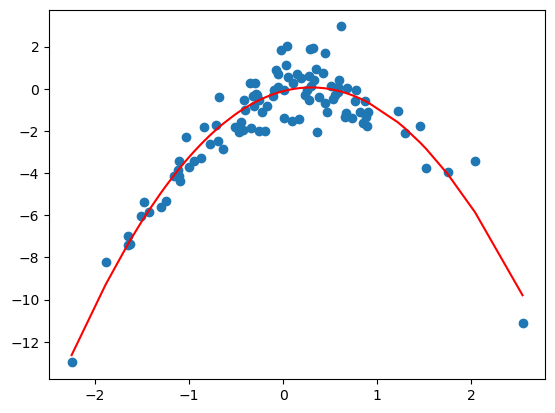

In [13]:
# Plot predictions as solid line
fig, ax = plt.subplots()
ax.scatter(x_train['x'],y_train)
quadratic=x_train[['x','pred_sq']].sort_values('x')
ax.plot(quadratic['x'],quadratic['pred_sq'], color='red')

In [14]:
# Fit a cubic model
model_cubic = sm.OLS(y_train, x_train[['intercept','x','x_sq','x_cu']])
results_cubic = model_cubic.fit()
summarize(results_cubic)

/Users/mjl09005/anaconda3/lib/python3.11/site-packages/ISLP/models/__init__.py:49: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  results_table = pd.read_html(tab.as_html(),


,coef,std err,t,P>|t|
intercept,-0.1223,0.115,-1.064,0.290
x,1.2533,0.189,6.633,0.000
x_sq,-1.9384,0.087,-22.153,0.000
x_cu,-0.0332,0.062,-0.534,0.595


In [15]:
# Get predictions
x_train['pred_cu'] = predict(x_train[['intercept', 'x','x_sq','x_cu']], results_cubic)

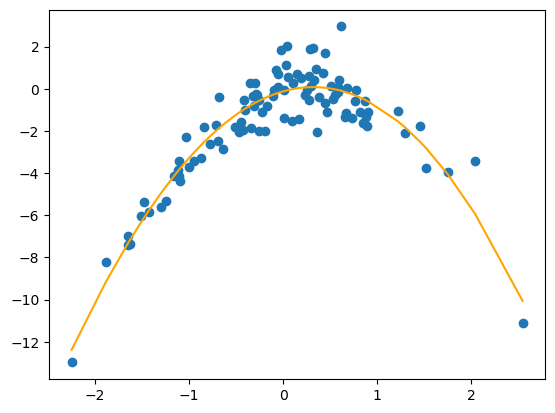

In [16]:
# Plot predictions as solid line
fig, ax = plt.subplots()
ax.scatter(x_train['x'],y_train)
cubic=x_train[['x','pred_cu']].sort_values('x')
ax.plot(cubic['x'],cubic['pred_cu'], color='orange')

In [17]:
# Calculate the MSE on the training set for each model
predictions_lin_train = predict(x_train[['intercept', 'x']], results_lin)
predictions_quad_train = predict(x_train[['intercept', 'x', 'x_sq']], results_quad)
predictions_cubic_train = predict(x_train[['intercept', 'x', 'x_sq', 'x_cu']], results_cubic)
print('mse train linear   :',mse(y_train, predictions_lin_train))
print('mse train quadratic:',mse(y_train, predictions_quad_train))
print('mse train cubic    :',mse(y_train, predictions_cubic_train))

mse train linear   : 5.675133917571525
mse train quadratic: 0.8628147238960371
mse train cubic    : 0.8602607634782035


In [18]:
# Calculate the MSE on the test set for each model
predictions_lin_test = predict(x_test[['intercept', 'x']], results_lin)
predictions_quad_test = predict(x_test[['intercept', 'x', 'x_sq']], results_quad)
predictions_cubic_test = predict(x_test[['intercept', 'x', 'x_sq', 'x_cu']], results_cubic)
print('mse test linear   :',mse(y_test, predictions_lin_test))
print('mse test quadratic:',mse(y_test, predictions_quad_test))
print('mse test cubic    :',mse(y_test, predictions_cubic_test))

mse test linear   : 10.065186883811217
mse test quadratic: 0.9598720616005347
mse test cubic    : 1.0269194510918034


In [19]:
# Calculate CV error w/ 5 folds for linear model
M = sklearn_sm(sm.OLS)
M_CV = cross_validate(M,
                      x_train[['intercept','x']],
                      y_train,
                      cv=5)
print(M_CV['test_score'])
cv_error_lin = np.mean(M_CV['test_score'])
print('estimated mse test:', cv_error_lin)

[ 4.33878408  5.83583034  2.13290121 13.26174966  4.3754383 ]
estimated mse test: 5.988940716896161


In [20]:
# Calculate CV error w/ 5 folds for quadratic model
M = sklearn_sm(sm.OLS)
M_CV = cross_validate(M,
                      x_train[['intercept','x','x_sq']],
                      y_train,
                      cv=5)
print(M_CV['test_score'])
cv_error_quad = np.mean(M_CV['test_score'])
print('estimated mse test:', cv_error_quad)

[1.34843589 0.66089087 0.4939185  1.65283991 0.6587921 ]
estimated mse test: 0.9629754540961665


In [21]:
# Calculate CV error w/ 5 folds for cubic model
M = sklearn_sm(sm.OLS)
M_CV = cross_validate(M,
                      x_train[['intercept','x','x_sq','x_cu']],
                      y_train,
                      cv=5)
print(M_CV['test_score'])
cv_error_cubic = np.mean(M_CV['test_score'])
print('estimated mse test:', cv_error_cubic)

[1.3635614  0.7853148  0.48556897 2.15444123 0.67200079]
estimated mse test: 1.0921774390176615
